# Preparing to start

## Preparing the enviroment


*   Attaching the libraries
*   Setting the global variables
*   Defining new paths

In [ ]:
import sys
import warnings
from google.colab import drive

DATASET         = 'CICIDS2017_sample.csv'
TARGET          = 'Label'
CLUSTER_COUNTS  = 7
BASE_PATH       = '/content/gdrive/MyDrive/Nasim/'
DATA_PATH       = BASE_PATH + ''
MODULE_PATH     = BASE_PATH + '/CICIDS_DATASETS/Modules'

warnings.filterwarnings("ignore")
sys.path.append(MODULE_PATH)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import euclidean_distances
import xgboost as xgb
from xgboost import plot_importance
from sklearn.feature_selection import mutual_info_classif
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
from sklearn.decomposition import KernelPCA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Modules

*   Defined all procedures for analysing the dada

### Components

In [ ]:
def load_dataset(file_name, target_name = TARGET, path = DATA_PATH):
  print(">>> Loading dataset:")
  if file_name.endswith('csv'):
    data = pd.read_csv(path + file_name)
    classes = np.empty((0,))
    n_labels = 'Not Exists'
    n_classes = 'Unrecognized'
    if target_name is not None:
      classes = pd.unique(data[target_name])
      n_labels = data[target_name].shape[0]
      n_classes = classes.shape[0]
    print(f"\tFeatures: {data.shape[0]}\n\tLabels: {n_labels}\n\tClasses: ({n_classes}) {classes}")
    return data

def feature_label_seperator(data, target_name = TARGET):
  print(">>> Seperating Feature & Labels:")
  X = data.iloc[:, data.columns != target_name]
  y = data[target_name]
  print(f"\tOriginal: {data.shape}\n\tFeatures: {X.shape[0]}\n\tLabels: {y.shape[0]}")
  return X, y

def feature_lable_combinator(features, labels, target_name = TARGET):
  print(">>> Features and labels are combined:")
  features = pd.DataFrame(features)
  data = features.copy()
  data[target_name] = labels
  print(f"\tOriginal: {features.shape}\n\tResult: {data.shape}")
  return data

def drop_sample(features, labels, target_values):
  print(f">>> Drop minor sample: {target_values}: {features.shape[0]}")
  data = feature_lable_combinator(features, labels)
  if len(target_values) > 0:
    data = data.drop(data[data[TARGET].isin(target_values)].index)
  features, labels = feature_label_seperator(data)
  print(f"\tOriginal: {features.shape[0]}\n\tResult: {features.shape[0]}")
  return features, labels

def min_max_normalizer(data):
  print(">>> Min-Max Normalizing:")
  scaler = MinMaxScaler(feature_range=(0, 1))
  result = scaler.fit(data)
  result = scaler.transform(data)
  print(f"\tDone --- {result.shape}\n\tMaximum: {result.max()}\n\tMinimum: {result.min()}")
  return result

def std_normalizer(data):
  numeric_features = data.dtypes[data.dtypes != 'object'].index
  data[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
  data[numeric_features] = (data[numeric_features] - data[numeric_features].mean())/data[numeric_features].std()
  return data
  
def replace_misvalues(value, data):
  print(">>> Missed values replacment:")
  data.replace([np.inf, -np.inf], np.nan, inplace=True)
  nulls = data.isnull().sum().sum()
  print(f"\tDone --- {nulls} nulls is replaced by {value}")
  return data.fillna(value)

def label_encoder(labels):
  print(">>> Encoding labels:")
  labelencoder = LabelEncoder()
  en_labels = labelencoder.fit_transform(labels)
  print(f"\t{en_labels.shape[0]} labels are encoded as below:\n\tBefore: {pd.unique(labels.values.reshape(1, -1)[0])}\n\tAfter:  {pd.unique(en_labels)}")
  return en_labels

def minor_major_samples(max_frequency, data, target = TARGET):
  frequents = data[target].value_counts(normalize=True)
  targets   = frequents[frequents < max_frequency].index
  minors    = data[data[target].isin(targets)]
  majors    = data.drop(minors.index)
  print(f">>> Majority analisys:\n\tMajors: {majors.shape}\n\tMinors: {minors.shape}")
  return minors, majors

def typical_sampling(majors, minors, target = TARGET, n_clusters = 1000, fraction = 0.008):
  print(">>> Data Sampling:")
  X = majors.drop([target], axis=1)
  s = majors.shape
  kmeans = MiniBatchKMeans(n_clusters).fit(X)
  majors['klabel'] = kmeans.labels_
  majors = majors.groupby('klabel', group_keys=False).apply(lambda group: group.sample(frac=fraction))
  majors = majors.drop(['klabel'],axis=1)
  result = majors.append(minors)
  print(f"\tInput sahpe: {s}\n\tSampled Data:\n\t\tMajors: {majors.shape}\n\t\tMinors: {minors.shape}\n\tResult: {result.shape}\n\tNumber of clusters: {n_clusters}\n\tFraction: {fraction}", )
  return result

def select_important_features(features, labels, threshold = 0.9):
  print(">>> Mutual important features:")
  features = pd.DataFrame(features)
  labels   = pd.DataFrame(labels)
  importances = mutual_info_classif(features, labels)
  sum = np.sum(importances)
  important_features = sorted(zip(map(lambda x: round(x, 4), importances/sum), features), reverse=True)
  selected_features = []
  portion = 0
  for i in range(len(important_features)):
    portion = portion + important_features[i][0]
    selected_features.append(important_features[i][1])
    if portion >= threshold:
      break
  rdc_features = features[selected_features]
  print(f"\tOriginal: {features.shape}\n\tReduced:  {rdc_features.shape}")
  return rdc_features

def Fast_CB_FS(features, labels, n_features = 10):
  print(">>> Fast Correlation-Based Feature Selection:")
  features = np.array(features)
  labels   = np.array(labels)
  fcbfk = FCBFK(k = n_features)
  print(f"\tObj: {fcbfk} ---Started: {features.shape}")
  rdc_features = fcbfk.fit_transform(features, labels)
  print(f"\tOriginal: {features.shape}\n\tReduced:  {rdc_features.shape}")
  return rdc_features

def kpca(features, labels, n = 5):
  print(">>> Kernel PCA:")
  kpca = KernelPCA(n_components = n, kernel = 'rbf')
  kpca.fit(features, labels)
  rdc_features = kpca.transform(features)
  print(f"\t#N components: {n}\n\tOriginal: {features.shape}\n\tReduced: {rdc_features.shape}")
  return rdc_features

def LDA(data, labels, n = 6):
  print(">>> Linear Discriminant Analysis:")
  clf = LinearDiscriminantAnalysis()
  clf.fit(data, labels)
  features = clf.transform(data)
  print(f"\t# of components: {n}\n\t# of Seen Features: {clf.n_features_in_}\n\tOriginal: {data.shape}\n\tReduced:  {features.shape}\n\tClasses:  {clf.classes_}\n\tVariation: {clf.explained_variance_ratio_} = {np.sum(clf.explained_variance_ratio_)}")
  return features

def oversampling(features, labels, strategy = 'not majority'):
  print(">>> Oversampling:")
  oversample = SMOTE(sampling_strategy = strategy)
  x, y = oversample.fit_resample(features, labels)
  print(f"Total Samples: {x.shape[0]}\n{pd.DataFrame(y).value_counts()}")
  return x, y

def save_todrive(result, name):
  print(">>> Save results to drive:")
  result.to_csv(DATA_PATH + name, index=0)
  print(f"\tDone --- {DATA_PATH+name}")

### Combined modules

In [ ]:
def preprocessing(data):
  print(f"\n----- PREPOCESSING OF : {data.shape} -----")
  ##### Fill empty values by 0 #####
  data = replace_misvalues(value = 0, data = data)

  ##### Feature and labels seperation #####
  features, labels = feature_label_seperator(data, TARGET)

  ##### Z-score normalization #####
  features = min_max_normalizer(features)

  ##### Encode all labels #####
  labels = label_encoder(labels)

  ##### retain the minority class instances and sample the majority class instances #####
  # data_minor, data_major = minor_major_samples(MINOR_RATE, data)

  ##### Data sampling #####
  # data =  typical_sampling(data_major, data_minor, TARGET, 1000, 0.008)

  ##### Same to drive #####
  # save_todrive(data, 'train_sampled_result.csv')

  ##### Feature reduction - mutual-information #####
  # features = select_important_features(features, labels, 0.9)

  ##### Fast corrolation-Based feature selection #####
  features = Fast_CB_FS(features, labels, n_features = 20)

  ##### Kernel PCA #####
  features = kpca(features, labels, 10)

  print(f"\n----- PREPOCESSING is COMPLETED : Samples: {features.shape[0]} Features: {features.shape[1]} Labels: {labels.shape} -----")
  return features, labels

### Confusion Matrix Visualization

In [ ]:
def visualize(model, X_test, y_test, y_predict):
  if model is not None:
    scores = model.score(X_test, y_test)
    print('Accuracy:\t'+ str(scores))
  precision, recall, fscore, none = precision_recall_fscore_support(y_test, y_predict, average='weighted') 
  print('Precision:\t'+(str(precision)))
  print('Recall: \t'+(str(recall)))
  print('F1-score:\t'+(str(fscore))+'\n')
  print(classification_report(y_test, y_predict))
  cm=confusion_matrix(y_test, y_predict)
  f,ax=plt.subplots(figsize=(5,5))
  sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax)
  plt.xlabel("y_pred")
  plt.ylabel("y_true")
  plt.show()
  return scores if model is not None else None

### Supervised Learning

In [ ]:
def S_Experiment(model, X_train, y_train, X_test, y_test):
  print(f'>>>>>----- Model: {str(model)} -----<<<<<\n')
  model.fit(X_train,y_train) 
  y_predict = model.predict(X_test)
  scores = visualize(model, X_test, y_test, y_predict)
  return model, y_predict, scores

### Unsupervised Learning

In [ ]:
def U_Experiment(model, X_train, y_train, X_test, y_test):
  print(f'>>>>>----- Model: {str(model)} -----<<<<<\n')
  model.fit(X_train)
  y_clusters_train = model.predict(X_train)
  y_clusters_test  = model.predict(X_test)
  df_new = feature_lable_combinator(X_train, y_train)
  lbls  = np.unique(y_train)
  print('y_train       :', lbls)
  candidates = []
  for i in range(len(lbls)):
    class_samples = df_new[df_new[TARGET] == lbls[i]]
    candid  = np.Inf
    samples = []
    for j in range(len(model.cluster_centers_)):
      distance = euclidean_distances(model.cluster_centers_[j].reshape(1, -1), class_samples.iloc[:,:-1])
      if np.min(distance) < candid:
        candid = np.min(distance)
        samples.append((np.min(distance), np.argmin(distance), j))
    candidates.append(class_samples.iloc[min(samples, key = lambda t: t[0])[1]])
  samples = pd.DataFrame(candidates)
  sample_clusters = model.predict(samples.iloc[:, :-1])
  print('Sample predict:', sample_clusters)
  real_labels = np.array(samples.iloc[:,-1], dtype=int)
  print('Sample real   :', real_labels)
  # mapped_clusters = {int(real_labels[i]):sample_clusters[i] for i in range(len(real_labels))}
  # sample_clusters = model.predict(X_test)
  # y_predict = np.array([mapped_clusters[y_clusters_test[i]] for i in range(len(y_clusters_test))])
  # scores = visualize(None, X_test, y_test, y_predict)
  return model, y_clusters_test, y_clusters_train

# Preparing data for processing


*   Loading the dataset
*   Splitting teh dataset
*   Preprocessing the trainset

### Load and normalizing

In [ ]:
##### Loadinf the dataset #####
df = load_dataset(file_name = DATASET, path = DATA_PATH)

##### Fill empty values by 0 #####
data = replace_misvalues(value = 0, data = df)

##### Feature and labels seperation #####
features, labels = feature_label_seperator(data, TARGET)

##### Z-score normalization #####
# features = min_max_normalizer(features)

##### Encode all labels #####
labels = label_encoder(labels)

>>> Loading dataset:
	Features: 56661
	Labels: 56661
	Classes: (7) ['BENIGN' 'DoS' 'PortScan' 'Bot' 'Infiltration' 'WebAttack' 'BruteForce']
>>> Missed values replacment:
	Done --- 162 nulls is replaced by 0
>>> Seperating Feature & Labels:
	Original: (56661, 78)
	Features: 56661
	Labels: 56661
>>> Encoding labels:
	56661 labels are encoded as below:
	Before: ['BENIGN' 'DoS' 'PortScan' 'Bot' 'Infiltration' 'WebAttack' 'BruteForce']
	After:  [0 3 5 1 4 6 2]


In [ ]:
pd.DataFrame(labels).value_counts().sort_index()

0    22731
1     1966
2     2767
3    19035
4       36
5     7946
6     2180
dtype: int64

In [ ]:
# Oversampling
features, labels = oversampling(features, labels)

>>> Oversampling:
Total Samples: 159117
0    22731
1    22731
2    22731
3    22731
4    22731
5    22731
6    22731
dtype: int64


### Feature Reduction

In [ ]:
##### retain the minority class instances and sample the majority class instances #####
# data_minor, data_major = minor_major_samples(MINOR_RATE, data)

##### Data sampling #####
# data =  typical_sampling(data_major, data_minor, TARGET, 1000, 0.008)

##### Same to drive #####
# save_todrive(data, 'train_sampled_result.csv')

##### Feature reduction - mutual-information #####
# features_m = select_important_features(features, labels, 0.9)
##### Fast corrolation-Based feature selection #####
# features_r = Fast_CB_FS(features_m, labels, n_features = 20)
##### Same to drive #####
# save_todrive(pd.DataFrame(features_r), 'fcbf_reduced_features_ADASYN.csv')

##### Kernel PCA #####
# features = kpca(features, labels, 5)

In [ ]:
##### Same to drive #####
# save_todrive(pd.DataFrame(features_r), 'fcbf_reduced_features.csv')

In [ ]:
##### Loadinf the dataset #####
features = load_dataset(file_name = 'fcbf_reduced_features.csv', target_name = None, path = DATA_PATH)

>>> Loading dataset:
	Features: 159117
	Labels: Not Exists
	Classes: (Unrecognized) []


In [ ]:
##### Loadinf the dataset #####
# features = load_dataset(file_name = 'fcbf_reduced_features_ADASYN.csv', target_name = None, path = DATA_PATH)

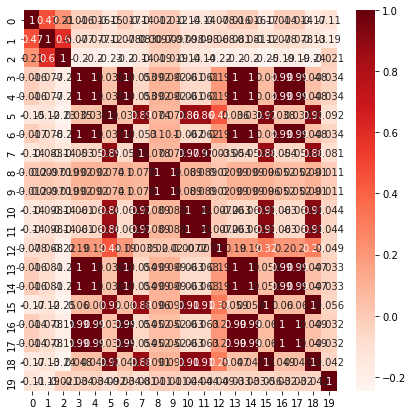

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(7,7))
cor = pd.DataFrame(features).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
##### Linear Discriminant Analysis #####
features = LDA(features, labels)

>>> Linear Discriminant Analysis:
	# of components: 6
	# of Seen Features: 20
	Original: (159117, 20)
	Reduced:  (159117, 6)
	Classes:  [0 1 2 3 4 5 6]
	Variation: [0.4746567  0.21711542 0.16930335 0.07474562 0.03965243 0.02452649] = 0.9999999999999998


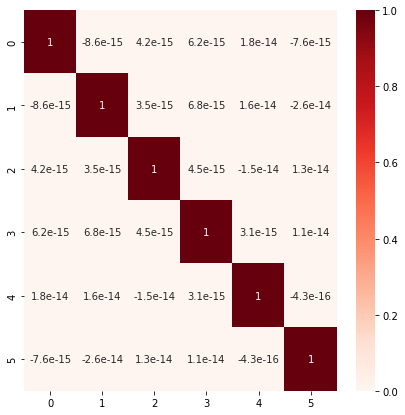

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(7,7))
cor = pd.DataFrame(features).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

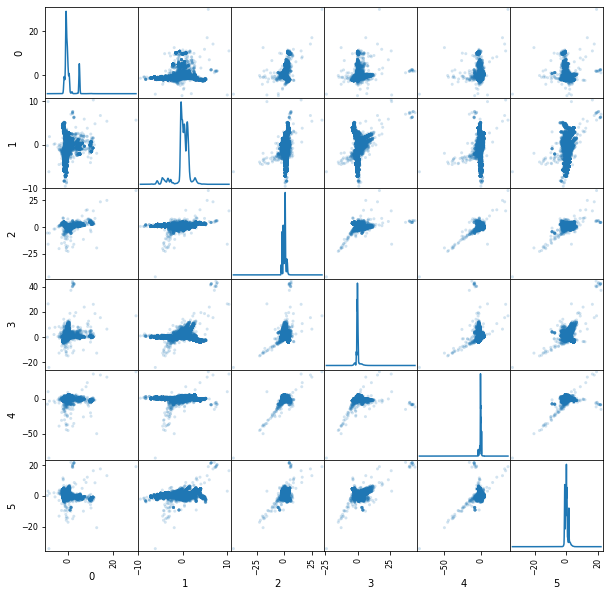

In [ ]:
from pandas.plotting import scatter_matrix
vis = scatter_matrix(pd.DataFrame(features), alpha=0.2, figsize=(10, 10), diagonal='kde')

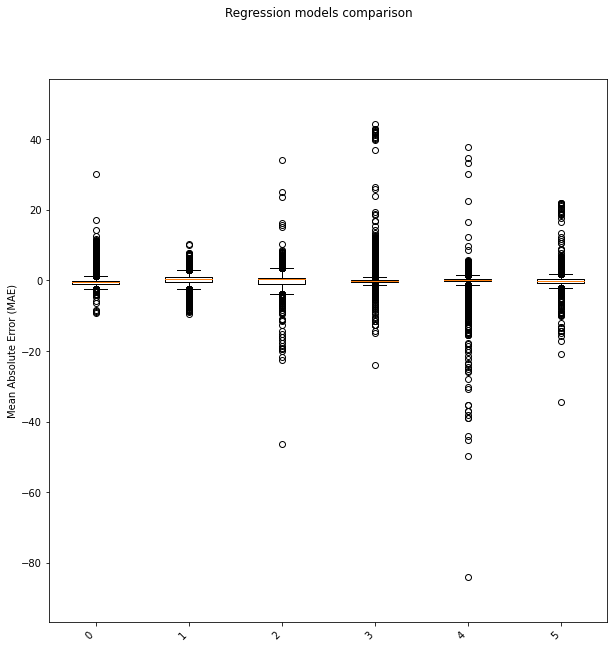

In [ ]:
# box-whisker plot to compare regression models
import matplotlib.pyplot as plt 
figure = plt.figure(figsize = (10,10))

trans_features = pd.DataFrame(features).T

figure.suptitle('Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(trans_features)
axis.set_xticklabels(trans_features, rotation = 45, ha="right")
axis.set_ylabel("Mean Absolute Error (MAE)")
plt.margins(0.05, 0.1)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 0, stratify = labels)
print(f">>> Dataset is splitted to:\n\tTrain Set: {X_train.shape}\t| Test Set: {X_test.shape} | All type of: {type(X_test)}")

>>> Dataset is splitted to:
	Train Set: (127293, 6)	| Test Set: (31824, 6) | All type of: <class 'numpy.ndarray'>



### Training the model

In [ ]:
from sklearn.mixture import GaussianMixture
from operator import itemgetter
gm = GaussianMixture(n_components = CLUSTER_COUNTS, verbose = 2, verbose_interval = 5, random_state=0).fit(X_train)
gm_pred_clusters = gm.predict(X_train)
df_k = feature_lable_combinator(X_train, y_train)
df_k = feature_lable_combinator(df_k, gm_pred_clusters, 'G_Cluster')

Initialization 0
  Iteration 5	 time lapse 1.61690s	 ll change 1.98601
  Iteration 10	 time lapse 1.37608s	 ll change 0.00284
  Iteration 15	 time lapse 1.39095s	 ll change 0.00162
  Iteration 20	 time lapse 1.37428s	 ll change 0.00312
  Iteration 25	 time lapse 1.37150s	 ll change 0.00959
  Iteration 30	 time lapse 1.41655s	 ll change 0.29623
  Iteration 35	 time lapse 1.39916s	 ll change 0.14497
  Iteration 40	 time lapse 1.40786s	 ll change 0.00113
Initialization converged: True	 time lapse 11.62780s	 ll 6.79390
>>> Features and labels are combined:
	Original: (127293, 6)
	Result: (127293, 7)
>>> Features and labels are combined:
	Original: (127293, 7)
	Result: (127293, 8)


The probablity of each label existance in different clusters from 0 to 6


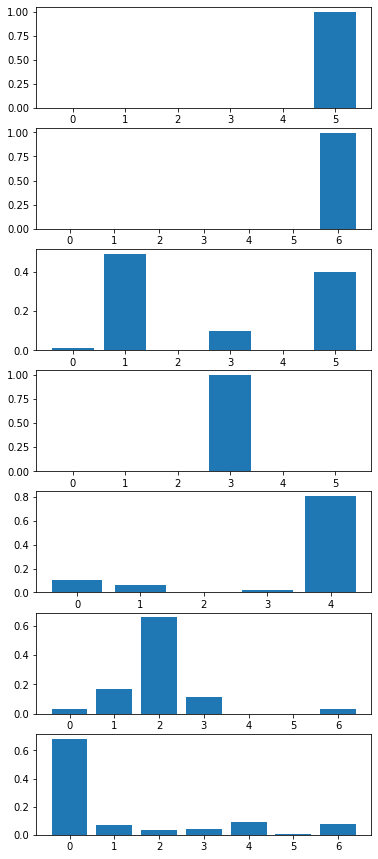

In [ ]:
fig, ax = plt.subplots(CLUSTER_COUNTS, 1)
plt.subplots_adjust(top=3)
priors = []
for i in range(CLUSTER_COUNTS):
  frq = df_k[df_k['G_Cluster'] == i][TARGET].value_counts(normalize=True).sort_index()
  priors.append([(frq.index[i], frq.values[i]) for i in range(len(frq))])
  ax[i].bar(frq.index, frq.values)
print(f'The probablity of each label existance in different clusters from 0 to 6')

### Finalizing

In [ ]:
y_gm = gm.predict(X_test)
y_gm = np.array([max(priors[y_gm[i]], key=itemgetter(1))[0] for i in range(len(y_gm))], dtype=int)
# df_k = feature_lable_combinator(df_k, gm_pred_labels, 'G_Label')

In [ ]:
import time
cluster = 'G_Cluster'
models = [RandomForestClassifier(n_estimators = 50) for i in range(CLUSTER_COUNTS)]
subsets = []
s_t_time = time.time()
for i in range(CLUSTER_COUNTS):
  subset = df_k[df_k[cluster] == i]
  f = subset.iloc[:, subset.columns.isin(range(CLUSTER_COUNTS))]
  l = subset[TARGET]
  subsets.append(np.unique(l))
  start_time = time.time()
  models[i].fit(f, l)
  # models[i][1].fit(f, l)
  end_tiem = time.time() - start_time
  print(f'Classifier {i+1} is trained in [{np.round(end_tiem, 3)} sec] with [{len(l)}] of samples, Bised with: [{np.bincount(l).argmax()}] in Cluster [{i}] of {np.unique(l)} ')
  print(l.value_counts())
print('--------------------------')
print(f'>>>>> Total training time: [{np.round(time.time() - s_t_time, 3)} sec]')

Classifier 1 is trained in [0.126 sec] with [9212] of samples, Bised with: [5] in Cluster [0] of [0 5] 
5    9208
0       4
Name: Label, dtype: int64
Classifier 2 is trained in [0.159 sec] with [15791] of samples, Bised with: [6] in Cluster [1] of [0 5 6] 
6    15717
5       38
0       36
Name: Label, dtype: int64
Classifier 3 is trained in [0.395 sec] with [22161] of samples, Bised with: [1] in Cluster [2] of [0 1 3 5] 
1    10893
5     8797
3     2215
0      256
Name: Label, dtype: int64
Classifier 4 is trained in [0.643 sec] with [11641] of samples, Bised with: [3] in Cluster [3] of [0 3 5] 
3    11567
0       70
5        4
Name: Label, dtype: int64
Classifier 5 is trained in [1.497 sec] with [20196] of samples, Bised with: [4] in Cluster [4] of [0 1 3 4] 
4    16285
0     2107
1     1329
3      475
Name: Label, dtype: int64
Classifier 6 is trained in [0.745 sec] with [26678] of samples, Bised with: [2] in Cluster [5] of [0 1 2 3 6] 
2    17491
1     4458
3     2981
0      930
6    

In [ ]:
intersects = [[j for j in range(len(subsets)) if np.isin(subsets[i], subsets[j]).all()] for i in range(CLUSTER_COUNTS)]

In [ ]:
intersects

[[0, 1, 2, 3, 6], [1, 6], [2, 6], [2, 3, 6], [4, 6], [5, 6], [6]]

In [ ]:
from tqdm import tqdm
clusters = gm.predict(X_test)
y_pred = np.array([models[clusters[i]].predict(X_test[i].reshape(1, -1)) for i in tqdm(range(len(clusters)))], dtype = int).flatten()

100%|██████████| 31824/31824 [05:14<00:00, 101.19it/s]


In [ ]:
clusters = gm.predict(X_test)
y_pred = np.empty((0,), dtype = int)
inv = 500
for i in range(len(clusters)):
  preds = np.empty((0,), dtype = int)
  for j in range(len(intersects[clusters[i]])):
    preds = np.append(preds, models[j].predict(X_test[i].reshape(1, -1)))
  if i % inv == 0: print(f"Cluster: {i} - Subset: {intersects[clusters[i]]}\n\tPredictions: {preds} >>>> ({np.bincount(preds).argmax()})")
  y_pred = np.append(y_pred, np.bincount(preds).argmax())

In [ ]:
from sklearn.metrics import accuracy_score
print(f'Total Accuracy: {np.round(accuracy_score(y_test, y_pred), 5)*100}%')

Total Accuracy: 99.504%


Precision:	0.9951312966025532
Recall: 	0.9951294620412268
F1-score:	0.9951289425236094

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4546
           1       1.00      1.00      1.00      4546
           2       1.00      1.00      1.00      4546
           3       1.00      0.99      1.00      4546
           4       1.00      1.00      1.00      4547
           5       1.00      1.00      1.00      4547
           6       0.99      1.00      0.99      4546

    accuracy                           1.00     31824
   macro avg       1.00      1.00      1.00     31824
weighted avg       1.00      1.00      1.00     31824



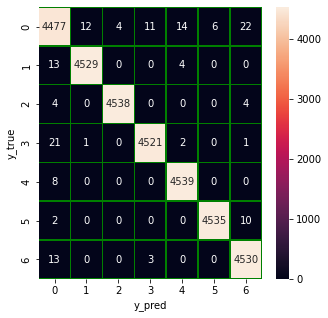

In [ ]:
visualize(None, X_test, y_test, y_pred)

In [ ]:
pd.DataFrame(labels).value_counts()

0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
dtype: int64